In [1]:
import os
os.chdir("../../..")
import deepof.data

In [2]:
%load_ext autoreload
%autoreload 2

# Formatting your data: feature extraction from motion tracking output

In [3]:
# Create and run a project. Explore different processing parameters (smoothing, imputation)

In [4]:
my_deepof_project = deepof.data.Project(
                path=os.path.join("../../Desktop/deepOF_CSDS_tutorial_dataset/"),
                arena="circular-autodetect",
                animal_ids=["B", "W"],
                video_format=".mp4",
                exclude_bodyparts=["Tail_1", "Tail_2", "Tail_tip"],
                video_scale=380,
                enable_iterative_imputation=True,
                exp_conditions={
                    '20191204_Day2_SI_JB08_Test_56': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_61': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_62': 'Stressed',
                    '20191204_Day2_SI_JB08_Test_54': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_63': 'Nonstressed',
                    '20191204_Day2_SI_JB08_Test_64': 'Nonstressed'
                }
)

# Set manually the edge in the polygons that we're measuring

In [15]:
my_deepof_project = my_deepof_project.run()

In [ ]:
# Save your project to avoid laborious repetitions

In [ ]:
my_deepof_project.save("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates")

In [6]:
# Load a previously saved project
my_deepof_project = deepof.data.load("../../Desktop/deepOF_CSDS_tutorial_dataset/deepof_tutorial_saved_coordinates_1667951748.pkl")

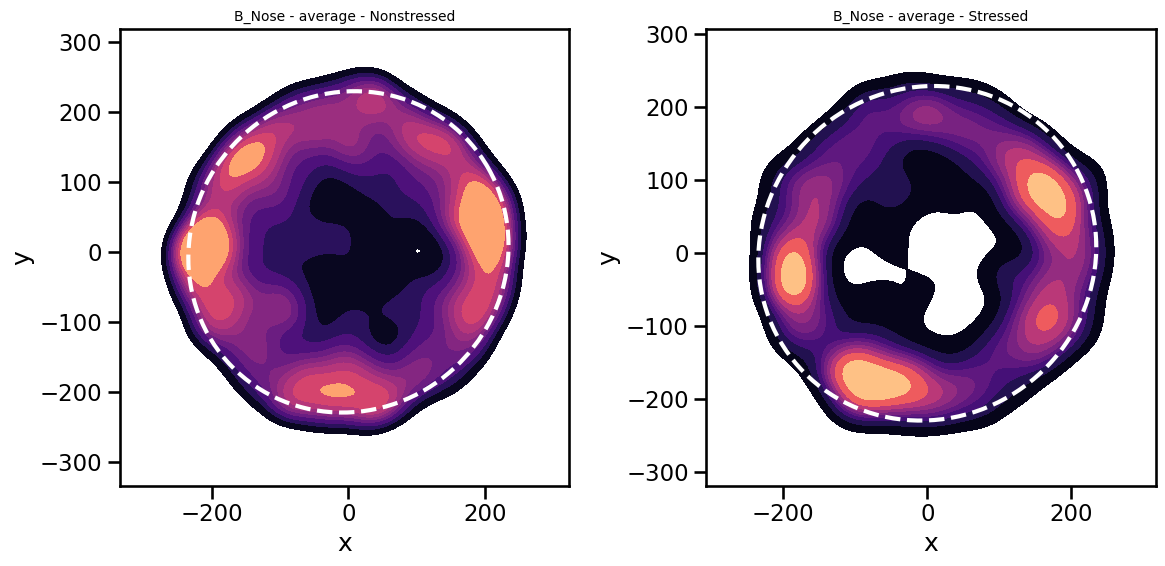

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import deepof.visuals
from matplotlib.patches import Ellipse

sns.set_context("talk")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Nonstressed",
    ax=ax1,
    show=False,
    display_arena=True,
    experiment_id="average",
)

deepof.visuals.plot_heatmaps(
    my_deepof_project, 
    ["B_Nose"],
    center="arena", 
    exp_condition="Stressed",
    ax=ax2,
    show=False,
    display_arena=True,
    experiment_id="average",
)

plt.tight_layout()
plt.show()

In [13]:
from sklearn.decomposition import PCA
emb_all = PCA(n_components=10).fit_transform(my_deepof_project.get_coords()['20191204_Day2_SI_JB08_Test_54'])
emb_B = PCA(n_components=10).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_54'])
emb_W = PCA(n_components=10).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("W")['20191204_Day2_SI_JB08_Test_54'])

In [89]:
def get_polygon_coords(data, animal_id=None):
    """
    
    Generates polygons to animate for all animals in the current dataframe
    
    """
    
    head = np.concatenate([tt.xs(f"{animal_id}Nose", 1).values,
            tt.xs(f"{animal_id}Left_ear", 1).values,
            tt.xs(f"{animal_id}Spine_1", 1).values,
            tt.xs(f"{animal_id}Right_ear", 1).values,
           ], axis=1)
    
    body = np.concatenate([
            tt.xs(f"{animal_id}Spine_1", 1).values,
            tt.xs(f"{animal_id}Left_fhip", 1).values,
            tt.xs(f"{animal_id}Left_bhip", 1).values,
            tt.xs(f"{animal_id}Spine_2", 1).values,
            tt.xs(f"{animal_id}Right_bhip", 1).values,
            tt.xs(f"{animal_id}Right_fhip", 1).values,
           ], axis=1)
    
    tail = np.concatenate([tt.xs(f"{animal_id}Spine_2", 1).values,
            tt.xs(f"{animal_id}Tail_base", 1).values,
           ], axis=1)
    
    return [head, body, tail]

In [90]:
import numpy as np

animal_id = "B"

tt = my_deepof_project.get_coords()['20191204_Day2_SI_JB08_Test_54']

polys = get_polygon_coords(tt, "B_")

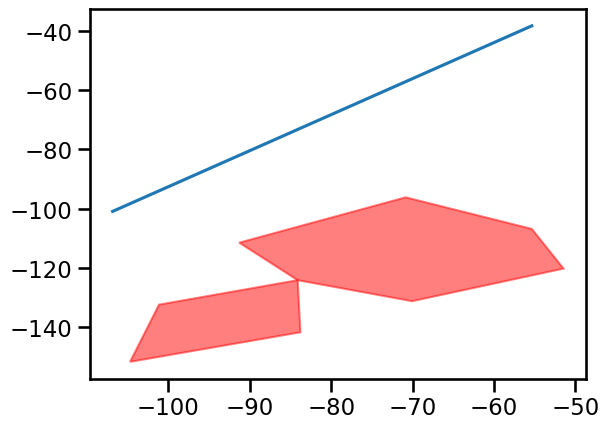

In [110]:
import matplotlib.patches as patches

fig = plt.figure()
ax = fig.add_subplot(111)

head = patches.Polygon(polys[0][0, :].reshape(-1, 2), closed=True, fc='r', ec='r', alpha=0.5)
body = patches.Polygon(polys[1][0, :].reshape(-1, 2), closed=True, fc='r', ec='r', alpha=0.5)
ax.plot(*polys[2][0, :].reshape(-1, 2))

ax.add_patch(head)
ax.add_patch(body)

plt.show()

In [146]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    #center="Center",
    #align="Spine_1",
    embedding=[emb_B, emb_W],
    # embedding=emb_all,
    #animal_id="B",
    experiment_id="20191204_Day2_SI_JB08_Test_54",
    frame_limit=500,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Single animal displayqawsedrftg[];'[pdfrtxe4swz3AQ@A˛

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords().filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
emb = PCA(n_components=3).fit_transform(my_deepof_project.get_coords(center="Center", align="Spine_1").filter_id("B")['20191204_Day2_SI_JB08_Test_56'])

In [ ]:
from IPython import display

video = deepof.visuals.animate_skeleton(
    my_deepof_project,
    center="Center",
    align="Spine_1",
    animal_id="B",
    embedding=emb,
    experiment_id="20191204_Day2_SI_JB08_Test_56",
    frame_limit=750,
    dpi=60,
)

html = display.HTML(video)
display.display(html)
plt.close()

In [ ]:
# Get and plot coordinates, distances, angles, and areas. Try and visualizing different centering and rotations

In [ ]:
my_deepof_project.get_coords(polar=True)['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_distances()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_angles()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
my_deepof_project.get_areas()

In [ ]:
my_deepof_project.get_areas()['20191204_Day2_SI_JB08_Test_54']

In [ ]:
# Show how to merge different feature objects

my_deepof_project.get_coords().pca()